In [401]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [402]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
df = train.append(test).reset_index()


In [403]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and col not in "SalePrice"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols, num_but_cat


cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 2919
Variables: 82
cat_cols: 52
num_cols: 28
cat_but_car: 1
num_but_cat: 10


In [404]:

def outlier_thresholds(dataframe, variable, low_quantile=0.01, up_quantile=0.99):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [405]:
def quick_missing_imp(data, num_method="median", cat_length=20, target="SalePrice"):
    variables_with_na = [col for col in data.columns if
                         data[col].isnull().sum() > 0]  # Eksik değere sahip olan değişkenler listelenir

    temp_target = data[target]

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    # değişken object ve sınıf sayısı cat_lengthe eşit veya altındaysa boş değerleri mode ile doldur
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x,
                      axis=0)

    # num_method mean ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    # num_method median ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    data[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data

In [406]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)

              n_miss  ratio
PoolQC          2909 99.660
MiscFeature     2814 96.400
Alley           2721 93.220
Fence           2348 80.440
SalePrice       1459 49.980
FireplaceQu     1420 48.650
LotFrontage      486 16.650
GarageCond       159  5.450
GarageYrBlt      159  5.450
GarageFinish     159  5.450
GarageQual       159  5.450
GarageType       157  5.380
BsmtExposure      82  2.810
BsmtCond          82  2.810
BsmtQual          81  2.770
BsmtFinType2      80  2.740
BsmtFinType1      79  2.710
MasVnrType        24  0.820
MasVnrArea        23  0.790
MSZoning           4  0.140
Functional         2  0.070
BsmtHalfBath       2  0.070
BsmtFullBath       2  0.070
Utilities          2  0.070
KitchenQual        1  0.030
TotalBsmtSF        1  0.030
BsmtUnfSF          1  0.030
GarageCars         1  0.030
GarageArea         1  0.030
BsmtFinSF2         1  0.030
BsmtFinSF1         1  0.030
Exterior2nd        1  0.030
Exterior1st        1  0.030
SaleType           1  0.030
Electrical         1

In [407]:
df["MSZoning"] = np.where(df.LotShape.isin(["C (all)", "RH"]), "CRH", df["MSZoning"])
df["Fireplaces"] = np.where(df.LotShape.isin(["4", "3"]), "43", df["Fireplaces"])
df["GarageCars"] = np.where(df.LotShape.isin(["4.000", "5.000"]), "45", df["GarageCars"])
df["Condition1"] = np.where(df.LotShape.isin(["RRNn", "RRNe","RRAn"]), "RRR", df["Condition1"])
df["Exterior2nd"] = np.where(df.LotShape.isin(["AsbShng", "AsphShn"]), "AA", df["Exterior2nd"])
df["Exterior2nd"] = np.where(df.LotShape.isin(["Brk Cmn", "BrkFace"]), "BB", df["Exterior2nd"])
df["Exterior2nd"] = np.where(df.LotShape.isin(["Other", "Stone","CBlock"]), "OSC", df["Exterior2nd"])
df["Total_Floor"] = df["1stFlrSF"] + df["2ndFlrSF"]
df["Build"] =df["YearRemodAdd"]- df["YearBuilt"]


In [408]:
drop_list = ["MiscFeature","Fence","PoolQC","GarageCond","GarageQual",
             "FireplaceQu"]
df.drop("Alley", axis=1, inplace=True)

# drop_list'teki değişkenlerin düşürülmesi
df.drop(drop_list, axis=1, inplace=True)

In [409]:
df.drop("Heating", axis=1, inplace=True)

In [410]:

del df["index"]

In [411]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 2919
Variables: 75
cat_cols: 44
num_cols: 29
cat_but_car: 1
num_but_cat: 8


In [412]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)
for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df,col)

Observations: 2919
Variables: 75
cat_cols: 44
num_cols: 29
cat_but_car: 1
num_but_cat: 8


In [413]:
## Son değişiklikler 
df['Build'].replace(-1, np.nan, inplace= True)
df.drop("PoolArea", axis=1, inplace=True)

In [328]:
Year_col = [col for col in df[num_cols] if "Year" in col]
Year_col

['YearBuilt', 'YearRemodAdd']

In [414]:
df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinSF1          1
BsmtFinType2       80
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBa

In [415]:
df["GarageYrBlt"].fillna(df["GarageYrBlt"].mode()[0]).isnull().sum()


0

In [416]:
df["LandSlope"].value_counts()

Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64

In [417]:
df["BsmtFinSF1"].value_counts()

0.000       929
24.000       27
16.000       14
300.000       9
288.000       8
384.000       8
600.000       8
20.000        8
700.000       7
500.000       7
602.000       7
456.000       7
624.000       7
375.000       7
936.000       7
360.000       7
312.000       6
468.000       6
528.000       6
120.000       6
625.000       6
588.000       6
662.000       6
504.000       6
276.000       6
544.000       6
553.000       6
560.000       6
368.000       6
547.000       6
336.000       5
648.000       5
196.000       5
28.000        5
144.000       5
1200.000      5
550.000       5
252.000       5
400.000       5
104.000       5
432.000       5
732.000       5
758.000       5
767.000       5
353.000       5
330.000       5
672.000       5
168.000       5
904.000       5
637.000       5
697.000       5
450.000       5
686.000       5
616.000       5
784.000       5
280.000       5
250.000       5
595.000       5
915.000       5
483.000       4
781.000       4
495.000       4
828.000 

In [418]:
df["LandSlope"].value_counts()

Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64

In [333]:
aggregations_MS = {"LotFrontage":["sum","mean"],
                    "LotArea": ["min", "mean","sum","max"],
                    "Street":["nunique", "size"],
                     "LandContour": ["nunique"],
                    "LandSlope": ["nunique"]}

 

In [334]:
 MSZoning = df.groupby('MSZoning').agg(aggregations_MS)

In [335]:
 MSZoning.columns = pd.Index(['MSZoning' + e[0] + "_" + e[1].upper() for e in MSZoning.columns.tolist()])
 
 df.drop(["LotFrontage","MiscVal", "LotArea", "Street", "LandContour", "LandSlope" ],axis=1, inplace=True)
    
 
 df = df.join(MSZoning, how='left', on='MSZoning')   

In [336]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 2919
Variables: 79
cat_cols: 52
num_cols: 25
cat_but_car: 1
num_but_cat: 19


In [309]:
df[num_cols].head()

,Id,MSSubClass,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageYrBlt,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,MSSubClassGarageArea_SUM,MSSubClassGarageArea_MEAN,MSSubClassWoodDeckSF_MEAN,MSSubClassWoodDeckSF_SUM,MSSubClassWoodDeckSF_MAX,MSSubClassOpenPorchSF_MEAN,MSSubClassOpenPorchSF_SUM,MSSubClassOpenPorchSF_MAX,MSSubClassTotRmsAbvGrd_MEAN,MSSubClassTotalBsmtSF_MEAN,MSSubClassTotalBsmtSF_SUM,MSSubClassTotalBsmtSF_MAX
0,1.000,60,7.000,2003,2003,196.000,706.000,0.000,150.000,856.000,854.000,0.000,1710.000,2003.000,0,0,0.000,0.000,2.000,335996.000,584.341,133.231,76608.000,870.000,79.897,45941.000,570.000,7.809,1020.469,586769.750,5495.750
1,2.000,20,6.000,1976,1976,0.000,978.000,0.000,284.000,1262.000,0.000,0.000,1262.000,1976.000,0,0,0.000,0.000,5.000,546168.000,506.180,97.281,104966.000,857.000,46.750,50443.000,484.000,6.027,1252.864,1350587.000,5095.000
2,3.000,60,7.000,2001,2002,162.000,486.000,0.000,434.000,920.000,866.000,0.000,1786.000,2001.000,0,0,0.000,0.000,9.000,335996.000,584.341,133.231,76608.000,870.000,79.897,45941.000,570.000,7.809,1020.469,586769.750,5495.750
3,4.000,70,7.000,1915,1970,0.000,216.000,0.000,540.000,961.000,756.000,0.000,1717.000,1998.000,272,0,0.000,0.000,2.000,47870.000,376.929,63.109,8078.000,530.000,42.922,5494.000,312.000,7.227,734.141,93970.000,1370.000
4,5.000,60,8.000,2000,2000,350.000,655.000,0.000,490.000,1145.000,1053.000,0.000,2198.000,2000.000,0,0,0.000,0.000,12.000,335996.000,584.341,133.231,76608.000,870.000,79.897,45941.000,570.000,7.809,1020.469,586769.750,5495.750


In [337]:
aggregations_BC = {"GarageArea":["sum","mean"],
                    "WoodDeckSF": ["mean","sum","max"],
                    "OpenPorchSF":["min", "mean","sum","max"],
                     "TotRmsAbvGrd": ["mean", "size"],
                    "TotalBsmtSF": ["mean","sum","max"],
                     "GrLivArea": ["min", "max", "size"],
                      "Build" : ["min","max"]}

In [338]:
MSSubClass = df.groupby('MSSubClass').agg(aggregations_BC)

In [339]:
 MSSubClass.columns = pd.Index(['MSSubClass' + e[0] + "_" + e[1].upper() for e in MSSubClass.columns.tolist()])

In [340]:
 df.drop(["Build", "GarageArea", "WoodDeckSF", "OpenPorchSF", "GrLivArea", "TotRmsAbvGrd", "TotalBsmtSF" ],axis=1, inplace=True)

In [341]:
df = df.join(MSSubClass, how='left', on='MSSubClass')   

In [342]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 2919
Variables: 90
cat_cols: 53
num_cols: 35
cat_but_car: 1
num_but_cat: 20


In [343]:
def one_hot_encoder(df, drop_first=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, drop_first=drop_first)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [344]:
df, cat_colls = one_hot_encoder(df)

In [349]:
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

In [350]:
train_df.dropna(inplace=True)

In [352]:
X =train_df.drop(["SalePrice", "Id"], axis=1)
y = np.log1p(train_df['SalePrice'])


In [353]:
X.shape, test_df.shape

((1371, 241), (1459, 243))

In [354]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [355]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(random_state=46)

rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model,
                                        X, y, cv=10, scoring="neg_mean_squared_error")))


In [356]:
lgbm_params = {"learning_rate": [0.01,0.02, 0.03, 0.04, 0.05, 0.1],
               "n_estimators": [500, 1500,2000, 5000, 6000, 7000, 8000, 9000, 10000, 15000],
                   }
 
lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=10,
                            n_jobs=-1,
                            verbose=True).fit(X_train, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


In [357]:

final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))

In [358]:
rmse

0.1270906636945339

In [359]:
lgbm_tuned = LGBMRegressor(**lgbm_gs_best.best_params_).fit(X_train, y_train)
y_pred = lgbm_tuned.predict(X_test)

In [222]:
## Log dönüşüm tersi
new_y= np.expm1(y_pred)
new_y_test= np.expm1(y_test)

In [360]:
test_dff = test_df.drop(["SalePrice", "Id"], axis=1)

In [296]:
test_dff.shape

(1459, 240)

In [361]:
y_predd = lgbm_tuned.predict(test_dff)

In [362]:
new_y= np.expm1(y_predd)


In [363]:
my_submission = pd.DataFrame({'Id': test_df["Id"], 'SalePrice': new_y})
# you could use any filename. We choose submission here
my_submission.to_csv('submission7.csv', index=False)

In [364]:
sub = pd.read_csv("./submission7.csv")

In [365]:
sub = sub.astype("int")


In [366]:
sub.to_csv('submission8.csv', index=False)

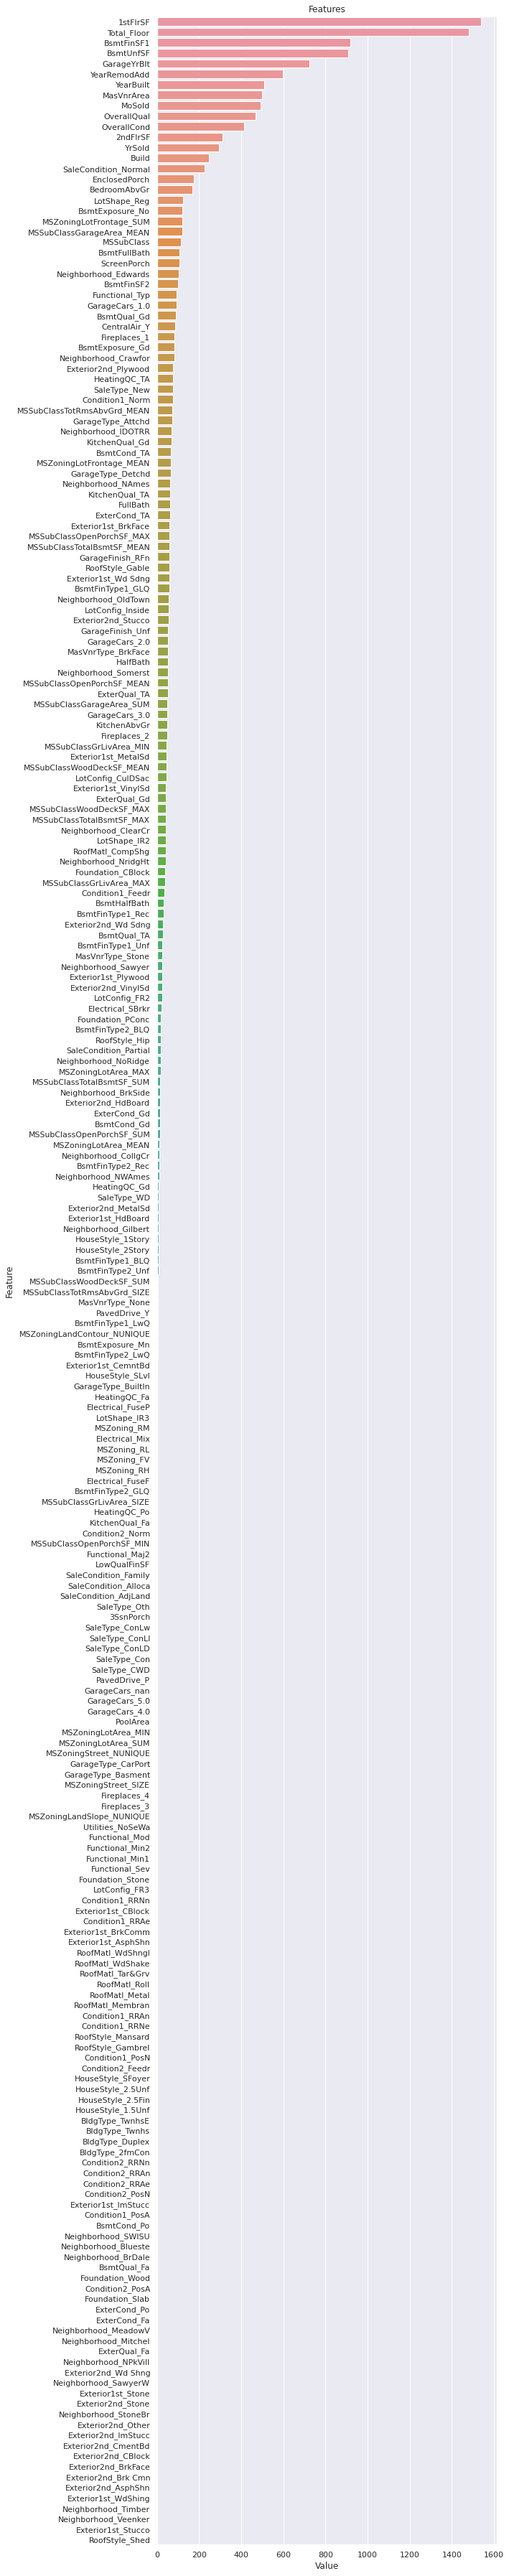

In [399]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 50))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
plot_importance(lgbm_tuned, X)